In [1]:
#import necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
import keras
from tensorflow.compat.v1.keras import backend as K
from tensorflow.keras.initializers import RandomNormal, Constant

In [2]:
# open training dataset and validation dataset 
train_img=pd.read_csv('../Datasets/train_img.csv')
valid_img=pd.read_csv('../Datasets/valid_img.csv')
train_img.drop(columns=['Unnamed: 0'],inplace=True)
valid_img.drop(columns=['Unnamed: 0'],inplace=True)

In [3]:
#set training parameters
IMAGE_SIZE = 240
BATCH_SIZE = 12

In [4]:
# configure image generator
img_gen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, vertical_flip   = True,
                               fill_mode = 'nearest', rotation_range = 10, width_shift_range = 0.2,
                               height_shift_range= 0.2, shear_range= 0.2, brightness_range= (0.5,1.2),
                               zoom_range = 0.2)
train = img_gen.flow_from_dataframe(train_img, directory = '../Datasets/train',x_col = 'filename', y_col = 'label', 
                                    target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                    batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)
val = img_gen.flow_from_dataframe(valid_img, directory = '../Datasets/train',x_col = 'filename', y_col = 'label', 
                                  target_size =(IMAGE_SIZE, IMAGE_SIZE), class_mode = 'categorical',
                                  batch_size = BATCH_SIZE, color_mode = 'rgb', shuffle = True)

Found 4807 validated image filenames belonging to 5 classes.
Found 424 validated image filenames belonging to 5 classes.


In [5]:
def create_model():
    # build neural network: efficientNet B3 + Batch Normalization + regularization
    model = Sequential()
    model.add(ResNet50(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights='imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation = 'softmax'))
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 24,113,541
Trainable params: 24,060,421
Non-trainable params: 53,120
_________________________________________________________________


In [6]:
#set training parameters
EPOCHS = 30
STEP_SIZE_TRAIN = train.n // train.batch_size
STEP_SIZE_TEST = val.n // val.batch_size

In [7]:
def model_fit(train,val):
    # implement training helpers, early stopping and LR monitor, use Adam as optimizer
    model = create_model()
    # smooth labels to reduce overfit  
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=1e-3)
    # initialize learning rate  
    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = loss, metrics = ['categorical_accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)
    # store best model
    checkpoint_cb = ModelCheckpoint("ResNet_best.h5",save_best_only=True,monitor='val_loss',mode='min')
    # reduce LR by 0.2 
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=2,min_lr=1e-10,mode='min',verbose=1)
    history = model.fit(train,validation_data=val,epochs=EPOCHS,batch_size=BATCH_SIZE,
                        steps_per_epoch=STEP_SIZE_TRAIN, validation_steps=STEP_SIZE_TEST,
                        callbacks=[es,checkpoint_cb, reduce_lr])    
    return history

In [8]:
# start training
with tf.device('/GPU:0'):
    results = model_fit(train,val)
    print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
    print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/30
377/377 [==============================] - 151s 361ms/step - loss: 1.5618 - categorical_accuracy: 0.4906 - val_loss: 1.4018 - val_categorical_accuracy: 0.4787
Epoch 2/30
377/377 [==============================] - 136s 361ms/step - loss: 1.1597 - categorical_accuracy: 0.5784 - val_loss: 3.2650 - val_categorical_accuracy: 0.2713
Epoch 3/30
377/377 [==============================] - 135s 357ms/step - loss: 1.1413 - categorical_accuracy: 0.5877 - val_loss: 1.3101 - val_categorical_accuracy: 0.6631
Epoch 4/30
377/377 [==============================] - 135s 356ms/step - loss: 1.1067 - categorical_accuracy: 0.6087 - val_loss: 7.5493 - val_categorical_accuracy: 0.4557
Epoch 5/30
377/377 [==============================] - 134s 356ms/step - loss: 1.0721 - categorical_accuracy: 0.6130 - val_loss: 1.2512 - val_categorical_accuracy: 0.5355
Epoch 6/30
377/377 [==============================] - 135s 356ms/step - loss: 1.0372 - categorical_accuracy: 0.6281 - val_loss: 1.1462 - val_categoric

In [9]:
def train_test_plot(acc, test_acc, loss, test_loss):
    # plot learning curves
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,5))
    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()

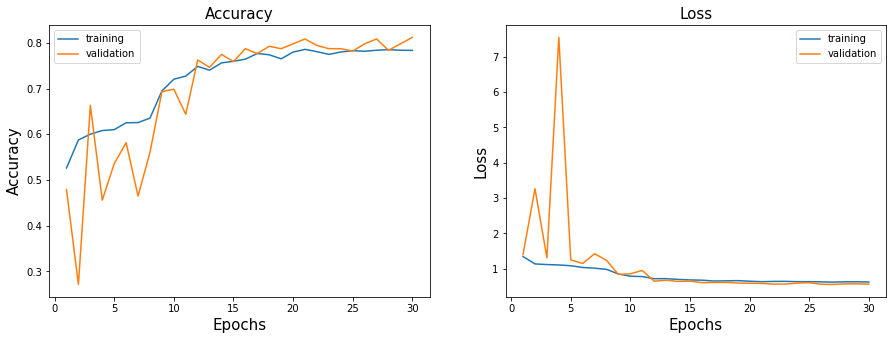

In [10]:
train_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)